# **PRELIMINARY INFORMATION**

This Notebook is devoted to the Feature Engineering of the **textual** field of the dataset. 

The idea is to use textual data of review to solve the **Topic Extraction** problem using **K-means++ clustering**.

*Note:* If during re-execution of the code some plots are not drawn in a large scale, execution of the cell one more time could help:)

# **SET UP**

## **Imports**

In [1]:
import os
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import re
from tqdm import tqdm
import numpy as np
from scipy.spatial.distance import cdist
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
import random
import timeit

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#for the repeatability of the experiments
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

## **Get and Unzip the Dataset**

In [3]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [5]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [6]:
!kaggle datasets download -d najzeko/steam-reviews-2021

100% 2.97G/2.97G [01:38<00:00, 58.1MB/s]
100% 2.97G/2.97G [01:38<00:00, 32.3MB/s]


In [7]:
!unzip \*.zip  && rm *.zip

Archive:  steam-reviews-2021.zip
replace steam_reviews.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## **Load Dataset in Pandas**

In order to fit into a local memory, we read dataset with a **chunksize** parameter.

In [8]:
chunk_df = pd.read_csv('steam_reviews.csv', chunksize=4000000)

Now with a simple cycle we can extract any number of chunks of data to perform experiments. 

Let's take just one chunk, corresponding to the **~600MB** of data.

In [9]:
for data in chunk_df:
    chunk = data
    break

In [10]:
#print dataset info to see fields specifications and check dataset memory consumption
chunk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 23 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   Unnamed: 0                      int64  
 1   app_id                          int64  
 2   app_name                        object 
 3   review_id                       int64  
 4   language                        object 
 5   review                          object 
 6   timestamp_created               int64  
 7   timestamp_updated               int64  
 8   recommended                     bool   
 9   votes_helpful                   int64  
 10  votes_funny                     int64  
 11  weighted_vote_score             float64
 12  comment_count                   int64  
 13  steam_purchase                  bool   
 14  received_for_free               bool   
 15  written_during_early_access     bool   
 16  author.steamid                  int64  
 17  author.num_games_owned     

## **Preliminary Cleaning and Partitioning**

Although the first clustering will be performed without any feature engineering technique applied, we still need to clean up the data to represent it in a form, appropriate for the input of clustering routine.

1. As it was noted by using Data Explorer provided by Kaggle web-page, that dataset contains reviwes from users all over the world (i.e. in different languages). Let's first **filter out all the non-english reviwes**.

In [11]:
df = chunk[chunk['language']=='english']

In [12]:
#drop language field, since it doesn't contain any relevant information for the clustering anymore
df = df.drop(['language'], axis = 1)

In [13]:
#check the size of new dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1819476 entries, 3 to 3999999
Data columns (total 22 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   Unnamed: 0                      int64  
 1   app_id                          int64  
 2   app_name                        object 
 3   review_id                       int64  
 4   review                          object 
 5   timestamp_created               int64  
 6   timestamp_updated               int64  
 7   recommended                     bool   
 8   votes_helpful                   int64  
 9   votes_funny                     int64  
 10  weighted_vote_score             float64
 11  comment_count                   int64  
 12  steam_purchase                  bool   
 13  received_for_free               bool   
 14  written_during_early_access     bool   
 15  author.steamid                  int64  
 16  author.num_games_owned          int64  
 17  author.num_reviews         

2. The second step of Preliminary Cleaning is **duplicates and nulls removal**. Regarding to the former: the check of the presence of duplicates has shown that they are not present in a given dataset, regarding to the latter: nulls are removed in a "total" fasion, i.e. whichever column they are contained in.

In [14]:
df = df.dropna(axis=0, how='any')

Now `df` $-$ raw dataframe to work on.

In [15]:
#preview of the dataframe
pd.set_option('display.max_colwidth', 100)
print("DATASET SHAPE:\n\n", df.shape, "\n\nDATASET:\n")
df.head(3)

DATASET SHAPE:

 (1813076, 22) 

DATASET:



,Unnamed: 0,app_id,app_name,review_id,review,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
3,3,292030,The Witcher 3: Wild Hunt,85184605,"One of the best RPG's of all time, worthy of any collection",1611379970,1611379970,True,0,0,0.0,0,True,False,False,76561199054755373,5,3,5587.0,3200.0,5524.0,1.611384e+09
5,5,292030,The Witcher 3: Wild Hunt,85184171,"good story, good graphics. lots to do.",1611379264,1611379264,True,0,0,0.0,0,True,False,False,76561198170193529,11,1,823.0,823.0,823.0,1.611379e+09
6,6,292030,The Witcher 3: Wild Hunt,85184064,"dis gud,",1611379091,1611379091,True,0,0,0.0,0,True,False,False,76561198119302812,27,2,4192.0,3398.0,4192.0,1.611352e+09


To determine the optimal number of clusters into which the data may be clustered, the smaller portion of data will be used.

Therefore, we **create mini-dataframe** `df_mini` by sampling `n` random rows of `df` (parameter `n` can vary, `n=10000` has shown to be enough).

In [16]:
df_mini = df.sample(n=10000)
print("MINI DATASET SHAPE:\n\n", df_mini.shape)

MINI DATASET SHAPE:

 (10000, 22)


# **UTILITIES**

Throught all of the experiments (without Feature Engineering (here and later FE) and with different approaches to FE), **Elbow Method**, referenced in the assignment ([https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/](https://)), will be used.

Utility `get_elbow` in a cell below takes as INPUT: 

1. Iterative object `K` with desired **maximum number of clusters** to be checked;
2. The **dataset** `data` to be clusterized with K-means++;
3. The **mode** of the experimental set-up `mode`, 

and returns as OUTPUT: 
1. List of **distortions** `distortions`, collected over iterations;
2. List of **inertias** `inertias`, collected over iterations.

In [17]:
#it has been investigated that taking 80 as a limit of iterative procedure provides representative plots of distortions and inertias
K = range(1, 80)
def get_elbow(K, data, mode):

  distortions = []
  inertias = []
  mapping1 = {}
  mapping2 = {}
 
  if (mode == "wfe" or mode == "tp"):
    data_to_fit = data
    data_dist = np.array(data.todense())
    data_shape = data.shape[0]
  elif mode == "e":
    data_to_fit = list(data)
    data_dist = np.array(list(data))
    data_shape = np.array(list(data)).shape[0]
  elif mode == "pca":
    data_to_fit = data
    data_dist = data
    data_shape = data.shape[0]

  for k in tqdm(K):
      #building and fitting the model
      kmeanModel = KMeans(n_clusters=k)
      kmeanModel.fit(data_to_fit)
  
      distortions.append(sum(np.min(cdist(data_dist, kmeanModel.cluster_centers_,
                                          'euclidean'), axis=1)) / data_shape)
      inertias.append(kmeanModel.inertia_)
  
      mapping1[k] = sum(np.min(cdist(data_dist, kmeanModel.cluster_centers_,
                                    'euclidean'), axis=1)) / data_shape
      mapping2[k] = kmeanModel.inertia_

  return distortions, inertias

Utility `plot_elbow` in a cell below takes as INPUT: 

1. Iterative object `K` with desired **maximum number of clusters** to be checked;
2. List of **distortions** `distortions`, collected over iterations;
3. List of **inertias** `inertias`, collected over iterations,

and DISPLAYS **evolution of the distortions and inertias**.

In [18]:
def plot_elbow(K, distortions, inertias):

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
  ax1 = axes[0]
  ax1.plot(K, distortions, 'bx-')
  ax1.set_xlabel('Values of K')
  ax1.set_ylabel('Distortion')
  ax1.set_title('The Elbow Method using Distortion')


  ax2 = axes[1]
  ax2.plot(K, inertias, 'bx-')
  ax2.set_xlabel('Values of K')
  ax2.set_ylabel('Inertia')
  ax2.set_title('The Elbow Method using Inertia')
  
  fig.tight_layout()

Utility `get_clusters` in a cell below takes as INPUT: 

1. Desired **number of clusters** `n_clusters`;
2. The **dataset** `data` to be clusterized with K-means++, 

and returns as OUTPUT the **model** `kmeans`.

In [19]:
def get_clusters(n_clusters, data):

  kmeans = KMeans(n_clusters = n_clusters, init = 'k-means++')
  kmeans.fit(data)
  return kmeans

Utility `print_common_words` in a cell below takes as INPUT: 

1. The **model** `kmeans`;
2. The **vectorizer** `tfv`,

and PRINTS **top-10 common words** for each of the centroids after the clustering.

In [20]:
def print_common_words(kmeans, tfv):
    
  common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
  words = tfv.get_feature_names_out()

  for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

Utility `plot_heatmap` in a cell below takes as INPUT the **dataframe** `df` with the joined `"clusters"` column,

and DISPLAYS **two heatmaps** to see: 

1. If the **recommended** items are clustered together;
2. If the **purhased** items are clustered together.

In [41]:
def plot_heatmap(df):

  #performing grouping
  #normalization is done due to the fact that dataset is not balanced and there are significantly more recommended items than not recommended
  recommendation_clusters = df.groupby(['cluster', 'recommended']).size() / df.groupby(['recommended']).size()

  fig, ax1 = plt.subplots(figsize = (16, 7))
  sns.heatmap(recommendation_clusters.unstack(level = 'recommended'), ax = ax1, cmap = 'Reds')
  ax1.set_xlabel('recommended').set_size(14)
  ax1.set_ylabel('cluster').set_size(14)

  purchasing_clusters = df.groupby(['cluster', 'steam_purchase']).size() / df.groupby(['steam_purchase']).size()

  fig, ax2 = plt.subplots(figsize = (16, 7))
  sns.heatmap(purchasing_clusters.unstack(level = 'steam_purchase'), ax = ax2, cmap = "Blues")
  ax2.set_xlabel('steam_purchase').set_size(14)
  ax2.set_ylabel('cluster').set_size(14)

Utility `plot_scatter` in a cell below takes as INPUT: 

1. The **number of components** `n_components` to keep in **PCA**;
2. The **dataframe** `df` with the joined `"clusters" `column;
3. The **number of items to sample** from dataframe for plotting `sample_size`;
4. The **vectorizer** `tfv`;
5. The **mode** of the experimental set-up `mode`,

and DISPLAYS the **scatter plot of clustering** in 2D or 3D.

In [61]:
def plot_scatter(n_components, df, sample_size, tfv=None, mode="wfe"):
  
  #sample desired number of raws of dataframe
  df_sampled = df.sample(n = sample_size)

  #prepare input accordingly to the mode
  if mode == "wfe":
    data = prepared_input_wfe(df_sampled['review'], tfv)
    X = np.array(data.todense())
    pca = PCA(n_components = n_components)
    Xtrain_pca = pca.fit_transform(X)
  elif mode == "tp":
    _, data = prepared_input_tp(df_sampled['review'].copy(), tfv)
    X = np.array(data.todense())
    pca = PCA(n_components = n_components)
    Xtrain_pca = pca.fit_transform(X)
  elif mode == "e":
    _, data = prepared_input_e(df_sampled['review'].copy())
    X = np.array(list(data))
    pca = PCA(n_components = n_components)
    Xtrain_pca = pca.fit_transform(X)
  elif mode == "pca":
    _, data = prepared_input_e(df_sampled['review'].copy())
    Xtrain_pca = prepared_input_pca(data, n_components)
    
  Ytrain_plot = df_sampled['cluster']

  if n_components == 2:
    plt.figure()
    plt.title("Scatter plot of clustered data in 2D")
    plt.scatter(Xtrain_pca[:,0], Xtrain_pca[:,1], c = Ytrain_plot, cmap = 'jet')
    plt.rcParams["figure.figsize"] = (12, 8)
    plt.show()

  if n_components == 3:
    fig = plt.figure()
    ax = Axes3D(fig)
    plt.title("Scatter plot of clustered data in 3D")
    ax.scatter(Xtrain_pca[:,0], Xtrain_pca[:,1], Xtrain_pca[:,2], c = Ytrain_plot, cmap = 'jet')
    plt.show()

# **CLUSTERING**

**K-means++** clustering technique has been chosen and implemented exploiting **Scikit-Learn** library. 

Four different experimental set-ups (approaches) for text clustering are implemented below:

> 1. **Without FE** (`mode = "wfe"`): raw textual field is used;

> **With FE**:

>> 2. Text Preprocessing (`mode = "tp"`);

>> 3. Embeddings (`mode = "e"`);

>> 4. PCA (`mode = "pca"`).

Each of the set-ups encouters the following **stages**:  

*   Preparation of the input data for the clustering;
*   Detection of the optimal `k` with `get_elbow`;
*   Fitting the model with prepared data and found `k`;
*   Plotting the results.

*Note-1:* Utilities for detection, fitting and plotting are essentially the same in all approaches, meanwhile utility for the preparation of the input data is individual and determines the approach.

*Note-2:* The more detailed analysis as well as motivation behind chosen approaches can be found in the **report**.


## **WITHOUT FE**

### **Preparation of the input data for the clustering**

In this approach we simply transform the text from the `"review"` field of the dataframe into a vector space using the **TfidfVectorizer** from Scikit-Learn which converts a collection of raw documents to a **matrix of TF-IDF features**.

In [23]:
tfv_wfe = TfidfVectorizer(ngram_range = (1,1))
def prepared_input_wfe(review, tfv):
  vectorized = tfv.fit_transform(review)
  return vectorized

In [24]:
#first we load reduced data to find optimal k
data_mini_wfe = prepared_input_wfe(df_mini['review'], tfv_wfe)

In [25]:
#resulting data type and shape
data_mini_wfe

<10000x18257 sparse matrix of type '<class 'numpy.float64'>'
	with 251893 stored elements in Compressed Sparse Row format>

In [26]:
#to see how our data looks right now

#e.g. take the first review
first_vector = data_mini_wfe[0] 
 
#display with pandas
first_vector_df = pd.DataFrame(first_vector.T.todense(), 
                  index = tfv_wfe.get_feature_names_out(), 
                  columns = ["tfidf"])
first_vector_df.sort_values(by = ["tfidf"], ascending = False)

,tfidf
menial,0.445376
relaxation,0.426401
task,0.361528
form,0.315628
driving,0.290283
...,...
fatigued,0.000000
fatilis,0.000000
fatshark,0.000000
fault,0.000000


### **Detection of the optimal `k` with `get_elbow`**

The current data format is not appropriate for the usage of the `cdist` method to compute distortions (inside `get_elbow`). 

The data need to be **reformatted** as in a cell below.

In [27]:
#reformatting
np.array(first_vector.todense())

array([[0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
distortions_wfe, inertias_wfe = get_elbow(K, data_mini_wfe, "wfe")

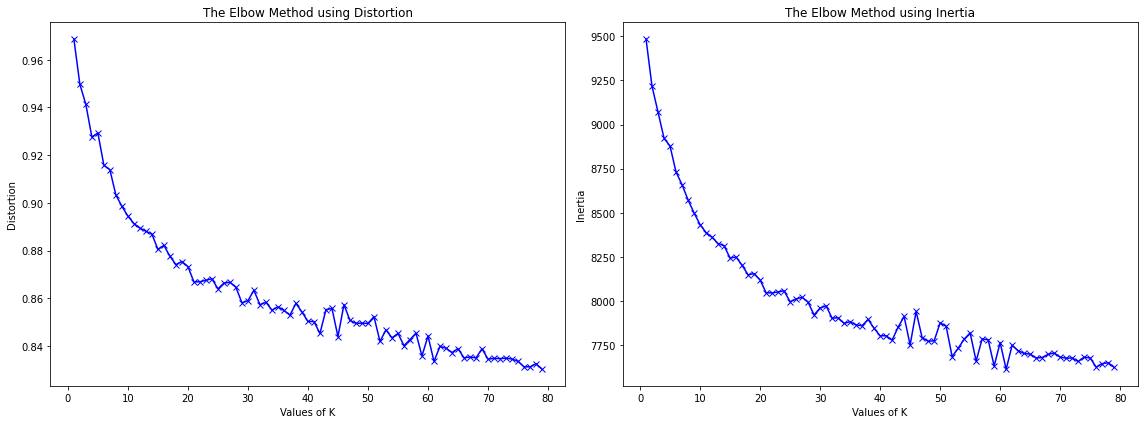

In [113]:
plot_elbow(K, distortions_wfe, inertias_wfe)

**Conclusion from plots:** The point after which the distortion/inertia starts decreasing in a linear fashion is about `k = 18`.

### **Fitting the model with prepared data and found `k`**

In [29]:
#for the model training we use the full data
data_wfe = prepared_input_wfe(df['review'], tfv_wfe)

In [30]:
start = timeit.default_timer()

kmeans_wfe = get_clusters(18, data_wfe)

stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  1846.9690212690002


### **Plotting the results**

**1. Print a list of common words for each of the clusters**

In [36]:
print_common_words(kmeans_wfe, tfv_wfe)

0 : game, good, cool, very, and, fun, for, my, to, the
1 : the, and, to, game, of, it, is, with, this, fun
2 : the, and, to, of, it, is, you, game, this, that
3 : gud, game, is, it, gam, very, gaem, its, iz, git
4 : nice, very, game, is, it, its, really, good, and, play
5 : amazing, game, is, this, it, an, its, just, simply, story
6 : yes, good, very, game, just, is, fun, it, this, buy
7 : pretty, good, its, it, fun, job, game, cool, far, so
8 : 10, would, game, again, the, best, this, 11, of, and
9 : fun, very, game, friends, it, with, is, play, really, to
10 : it, love, game, buy, like, is, and, just, good, but
11 : you, if, game, to, this, it, and, the, can, is
12 : its, good, fun, ok, game, guess, alright, cool, great, really
13 : good, game, very, it, is, really, this, so, stuff, shit
14 : best, ever, game, the, played, one, of, games, ve, have
15 : great, game, it, fun, is, story, friends, with, this, play
16 : this, game, is, love, it, and, the, to, so, like
17 : awesome, game, 

**Conclusion:** Centroids are affected by noise (at least stop-words removal is needed).

**2. Visualize the heatmaps to see how recommendations and purchases are clustered**

In [52]:
#add the cluster label to the dataframe
df_wfe = df.copy()
df_wfe['cluster'] = kmeans_wfe.labels_

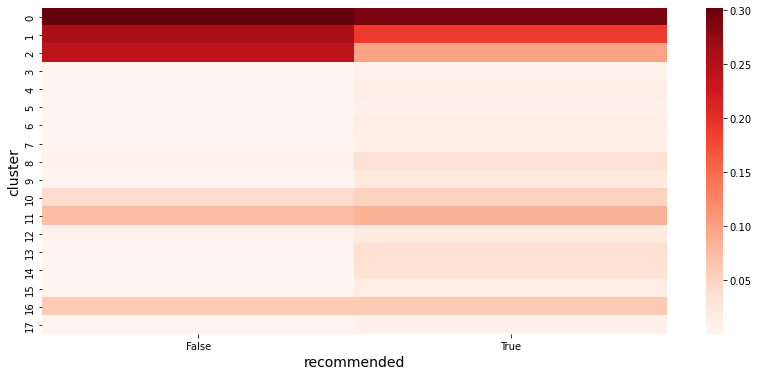

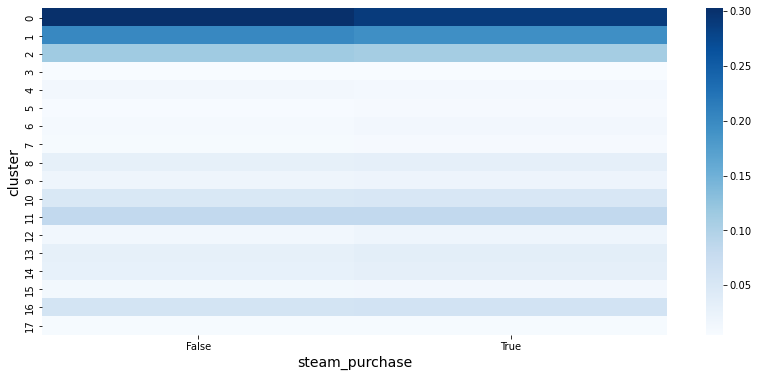

In [53]:
plot_heatmap(df_wfe)

**Conclusion from plots:** Clustering doesn't separate distributions over `"recommended"` and `"steam_purchase"` features.

**3. Plots of the clusters with data projected to 2D and 3D using `pca` from Scikit Learn**

Let's finally plot the results of the clustering for the 5000 (for the sake of execution time reduction) randomly sampled items.

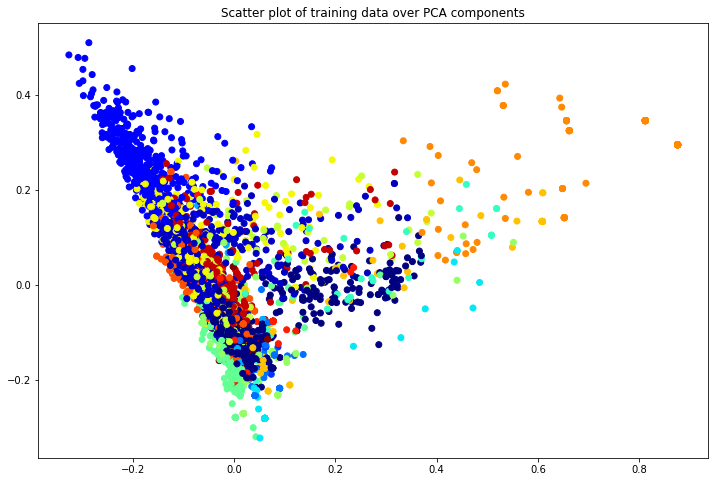

In [56]:
#2D plot
plot_scatter(2, df_wfe, 5000, tfv_wfe, "wfe")

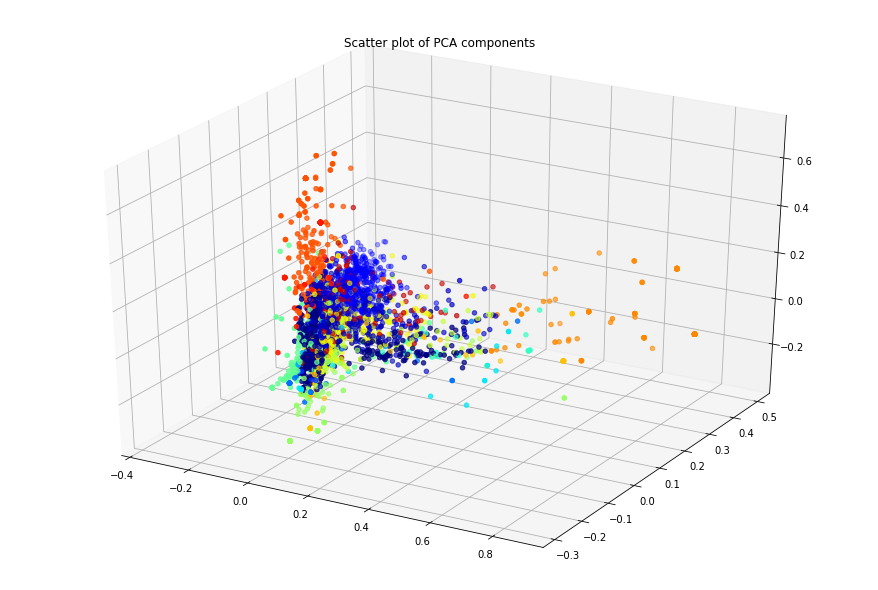

In [57]:
#3D plot
plot_scatter(3, df_wfe, 5000, tfv_wfe, "wfe")

**Conclusion from plots:** Some spatial patterns seem to be captured, but high overlapping of the clusters is present.

## **FE: TEXT PREPROCESSING**

In this experimental set-up instead of working with the raw textual data, the following steps of the **text preprocessing** will be performed:

*   Lowercasing;
*   Punctuation, digits, special characters removal;
*   Lemmatization;
*   Stop-words removal.

*Note:* Using **NLTK** library and **regular expressions**.



### **Preparation of the input data for the clustering**

In [60]:
tfv_tp = TfidfVectorizer(ngram_range = (1,1))
def prepared_input_tp(review, tfv):
  review = review.apply(lambda x: x.lower()) #lowercasing
  review = review.apply(lambda x: re.sub('[^a-zA-Z]', ' ', x)) #auxiliary characters removal
  review = review.apply(lambda x: re.sub(' +', ' ', x)) #auxiliary spaces removal
  review = review.apply(lambda x: [lemmatizer.lemmatize(token) for token in x.split() 
                                                              if not token in stop_words and len(token) > 2]) #split, stop-words removal and lemmatization
  review = review.apply(lambda x: ' '.join(x)) #joining tokens back to sentences to be fed into vectorizer
  vectorized = tfv.fit_transform(review) #apply re-initialized TfidfVectorizer
  return review, vectorized

In [65]:
#first we load reduced data to find optimal k
#feed the copy of the "review" column in order to not modify original dataframe
preprocessed_review_tp, data_mini_tp = prepared_input_tp(df_mini['review'].copy(), tfv_tp)

In [77]:
#resulting data type and shape
data_mini_tp

<10000x15127 sparse matrix of type '<class 'numpy.float64'>'
	with 158263 stored elements in Compressed Sparse Row format>

In [75]:
#let's print our textual field examples before and after text preprocessing
print("BEFORE TEXT PREPROCESSING:\n\n", df_mini['review'].head(10), "\n", "-"*110)
print("AFTER TEXT PREPROCESSING:\n\n", preprocessed_review_tp.head(10))
print('\n')

BEFORE TEXT PREPROCESSING:

 4105522       If you enjoy driving or doing menial task as a form of relaxation, i highly recommend this game.
4671740               Huge amount of backgrounds on the workshop and the editor is decent for making your own!
896586                                                                                1 of the all time greats
2882405                                                                                You become the cannibal
3157070    Epic game - Im happy that I saw a post on twitter telling that Cube World will be released on St...
2271368                                  I CANT EVEN CHANGE THE GRAPHIC TO STOP MY COMPUTER SCREEN BEING BLACK
1682949                          Badly coded, buggy, runs crappy, way too casual, too many dlcs, etc\n0/10 IGN
480287                                                                                                 crowbar
3892283                                                          Everlasting gamepl

### **Detection of the optimal `k` with `get_elbow`**

In [78]:
distortions_tp, inertias_tp = get_elbow(K, data_mini_tp, "tp")

100%|██████████| 79/79 [32:26<00:00, 24.64s/it]


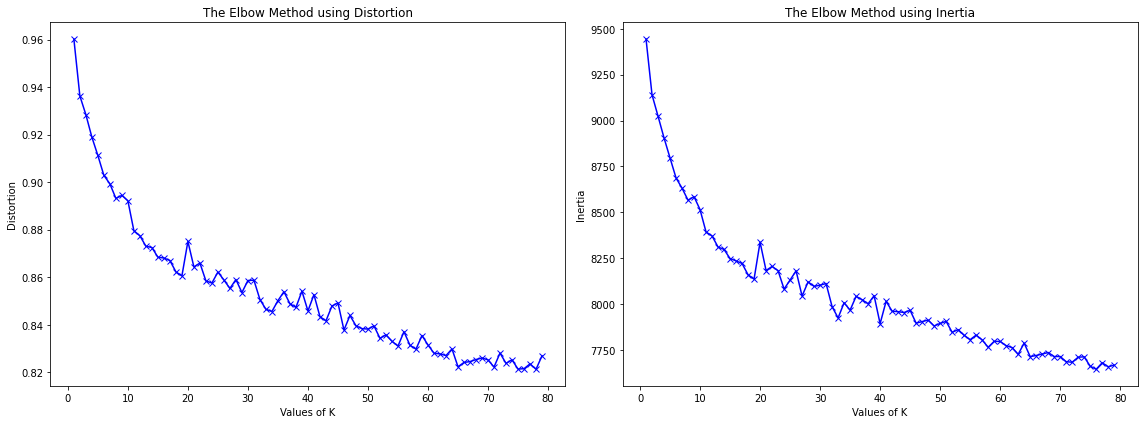

In [79]:
plot_elbow(K, distortions_tp, inertias_tp)

**Conclusion from plots:** the point after which the distortion/inertia starts decreasing in a linear fashion is again about `k = 18`.

### **Fitting the model with prepared data and found `k`**

In [80]:
#for the model training we use the full data
_, data_tp = prepared_input_tp(df['review'].copy(), tfv_tp)

In [81]:
start = timeit.default_timer()

kmeans_tp = get_clusters(18, data_tp)

stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  1067.9623447669983


### **Plotting the results**

**1. Print a list of common words for each of the clusters**

In [82]:
print_common_words(kmeans_tp, tfv_tp)

0 : amazing, game, story, simply, love, absolutely, fun, great, play, graphic
1 : good, game, fun, gud, get, would, play, wallpaper, great, epic
2 : game, great, fun, play, good, time, get, one, really, hour
3 : cool, game, pretty, wallpaper, really, fun, good, guess, play, nice
4 : better, portal, game, even, great, puzzle, good, first, one, get
5 : enjoyable, game, fun, really, play, friend, time, still, great, good
6 : fun, game, really, good, pretty, lot, play, super, hard, challenging
7 : great, game, fun, story, play, love, recommend, really, gameplay, lot
8 : good, game, pretty, really, stuff, play, story, get, real, still
9 : buy, game, good, must, worth, would, dont, already, great, fun
10 : best, ever, game, played, one, made, rpg, time, sandbox, survival
11 : nice, game, good, really, wallpaper, fun, pretty, play, graphic, like
12 : much, game, fun, love, play, good, time, like, pretty, played
13 : yes, good, game, fun, nice, buy, big, gud, play, much
14 : love, awesome, gam

**Conclusion:** data has been cleaned from the noise, however the centroids are semantically close to each other and contain large amount of repetative tokens which complicates clustering problem.

**2. Visualise the heatmaps to see how recommendations and purchases are clustered**

In [83]:
#add the cluster label to the dataframe
df_tp = df.copy()
df_tp['cluster'] = kmeans_tp.labels_

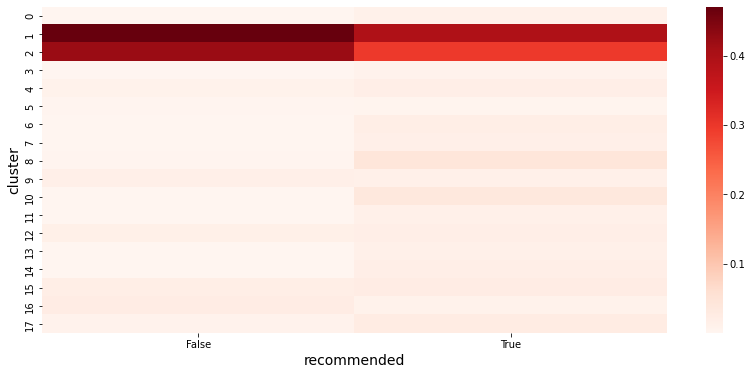

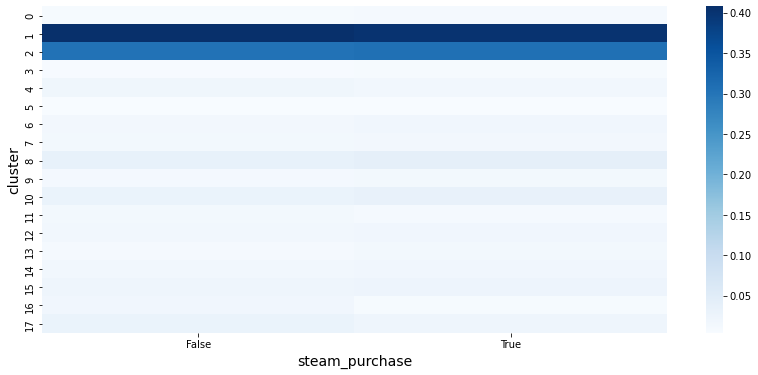

In [84]:
plot_heatmap(df_tp)

**Conclusion from plots:** data is heavily clustered in two clusters, separability over fileds of concern has not been improved.

**3. Plots of the clusters with data projected to 2D and 3D using `pca` from Scikit Learn**

Let's now again display scatter plots of the results of the clustering for the 5000 randomly sampled items and compare them with the results of the clustering based on the raw data to see if applied feature engineering technique improved the quality of a clusterizer.

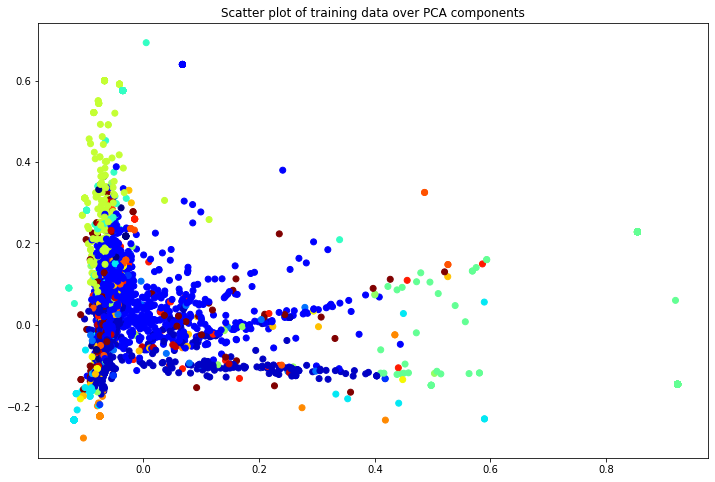

In [86]:
#2D plot
plot_scatter(2, df_tp, 5000, tfv_tp, "tp")

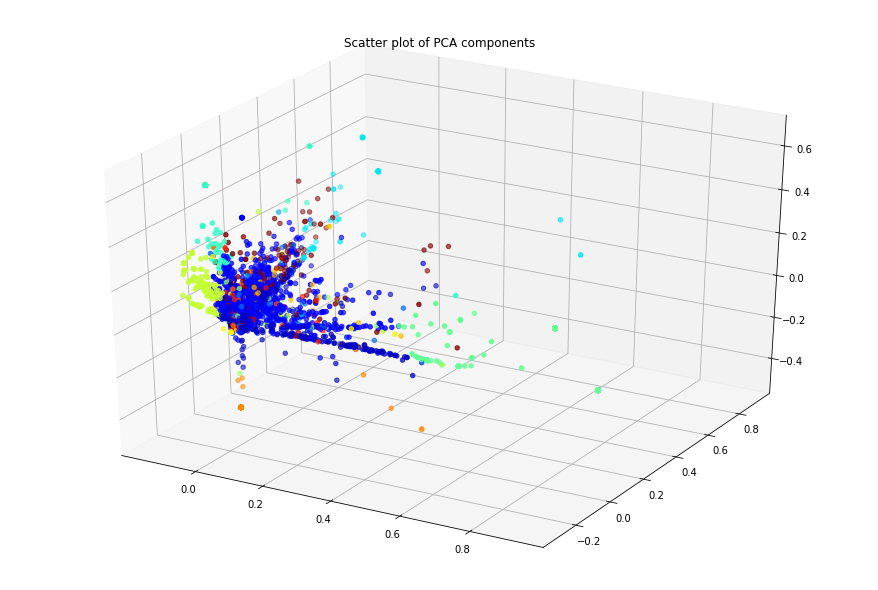

In [87]:
#3D plot
plot_scatter(3, df_tp, 5000, tfv_tp, "tp")

**Conclusion from plots:** data seems to be better structured than in the previous case, althouth the problem of overlapping hasn't been eliminated.

## **FE: EMBEDDINGS**

The following experimental set-up approaches feature engineering of the textual data with not only pure text preprocessing, but with the text **preprocessing+word embeggings** using **Global Vectors (GloVe)** $-$ an unsupervised learning algorithm for obtaining vector representations for words.

GloVe vectors of dimensionality **100d** will be loaded **as pre-trained** from the official web-page [https://nlp.stanford.edu/projects/glove/](https://) and used to transform the text from the `"review"` field of the dataframe into a vector space instead of TfidfVectorizer.

### **Preparation of the input data for the clustering**

In [23]:
#get GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
#rm all except for 100d
!rm glove.6B.50d.txt
!rm glove.6B.200d.txt
!rm glove.6B.300d.txt
!rm glove.6B.zip

--2021-12-04 00:48:55--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-12-04 00:48:56--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-04 00:48:56--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [24]:
#create dictionary that maps words as strings to their embedding vectors
def load_embeddings(embeddings_path):

    word_vectors = dict()
    with open(embeddings_path) as f:

        for i, line in tqdm(enumerate(f)):

            word, *vector = line.strip().split(' ')
            vector = np.array([float(c) for c in vector])
            word_vectors[word] = vector

    return word_vectors
word_vectors = load_embeddings('glove.6B.100d.txt')

400000it [00:20, 19821.05it/s]


In [25]:
#print example of the word embedding for th word "game"
word_vectors['game']

array([ 0.062659,  0.026003,  1.122   , -0.84123 , -0.56907 ,  0.86677 ,
        0.99235 , -0.19032 , -0.74226 , -0.29547 ,  0.037746, -0.71756 ,
       -0.44891 , -0.65801 ,  0.17469 ,  0.50347 ,  0.21268 ,  1.0438  ,
       -0.60034 ,  0.48838 ,  0.16955 , -0.070132, -0.070228,  0.50193 ,
        1.3543  , -0.27193 , -0.16449 ,  0.37399 , -0.14291 ,  0.19646 ,
       -0.80925 ,  0.86245 , -0.2118  , -0.074321,  0.38522 , -0.34137 ,
       -1.2694  ,  0.59967 , -0.84746 , -0.68818 ,  0.68874 , -0.19769 ,
        0.2064  , -0.20387 , -0.33651 ,  0.093972,  0.34192 , -0.68139 ,
        0.61451 , -0.88127 , -0.13401 , -0.088989, -0.098916,  0.73405 ,
        0.33496 , -3.1068  , -0.22643 , -0.21568 ,  1.3375  ,  1.5472  ,
       -1.2343  ,  0.42964 , -0.78932 , -0.027462,  0.34738 ,  0.17338 ,
        0.24975 , -0.010451, -0.71149 ,  0.55568 , -0.20869 ,  0.074445,
        0.29833 , -0.029668, -0.01595 ,  0.46368 , -0.80873 ,  0.11564 ,
       -0.14607 ,  0.73785 ,  0.33548 ,  0.18176 , 

In [26]:
def prepared_input_e(review):
  #the first part is the same as before, except for we don't join tokens back to the sentences now, because we want word embeddings
  review = review.apply(lambda x: x.lower()) #lowercasing
  review = review.apply(lambda x: re.sub('[^a-zA-Z]', ' ', x)) #auxiliary characters removal
  review = review.apply(lambda x: re.sub(' +', ' ', x)) #auxiliary spaces removal
  preprocessed_review = review.apply(lambda x: [lemmatizer.lemmatize(token) for token in x.split() 
                                                              if not token in stop_words and len(token) > 2]) #split, stop-words removal and lemmatization
  #we replace each word with its embedding stored in the word_vectors dictionary
  review = preprocessed_review.apply(lambda x: [word_vectors[w] for w in x if w in word_vectors])
  #we stack embeddings for all the words in the sentence together 
  review = review.apply(lambda x: np.stack(x) if len(x) > 0 else x)
  #the mean embedding is computed to represent the whole sentence
  review = review.apply(lambda x:  np.nanmean(x, axis=0))
  #if during stop-words removal some sentences became empty, they will imply empty arrays as embeddings
  #and further NaNs as the result of computational procedure, which should be dropped
  review = review.dropna()
  return preprocessed_review, review

In [27]:
#first we load reduced data to find optimal k
#feed the copy of the "review" column in order to not modify original dataframe
#get both review after pure data processing and after data processing+embedding to be able to print and verify correctness of intermediate steps
preprocessed_review_e, data_mini_e = prepared_input_e(df_mini['review'].copy())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


In [28]:
#resulting data and its shape
print("DATA SHAPE:\n\n", data_mini_e.shape, "\n\nDATA:\n")
data_mini_e.head(3)

DATA SHAPE:

 (9548,) 

DATA:



3608628    [-0.08441214285714287, 0.21985242857142856, 0.3733235714285713, -0.3517614285714286, -0.43880198...
3754496    [-0.08460616666666669, 0.24588074375000005, 0.31729705625000004, -0.29838589583333336, -0.106271...
872712     [-0.80416, 0.44516, -0.70324, 0.34495, -1.4166, -1.2829, -0.45764, -0.26724, 0.61213, -1.8521, -...
Name: review, dtype: object

In [29]:
#data before and after pure text preprocessing
print("BEFORE TEXT PREPROCESSING:\n\n", df_mini['review'].head(10), "\n", "-"*110)
print("AFTER TEXT PREPROCESSING:\n\n", preprocessed_review_e.head(10))
print('\n')

BEFORE TEXT PREPROCESSING:

 3608628    As someone who never played megaman x, this is a good game\n10/10\nfun multiplayer\ngood time ki...
3754496    It all began with a single ore... It was all so simple and easy... Now the only thing I see are ...
872712                                                                                                     Meh
2637733                                                                                             cool class
1994359                                                                                 pretty good job so far
2418541    This game is AMAZING!!!!\nPros: \n-Alot of fun to play\n-Completly new and original\n-Constantly...
2329520                                                                                              its great
1328273                                                                                         Tis a fun game
3832314    Fantastic and Fun.  I definately got my money worth. Finding the best wa

In [30]:
#let's sample one of the short preprocessed reviews to look at the output of the further steps
#choose the desired index
sampled_review = preprocessed_review_e[1328273]
sampled_review

['ti', 'fun', 'game']

In [31]:
#we see after this step each word from the tokenized sentence is represented by embedding of 100d
sentence_word_vector = [word_vectors[w] for w in sampled_review if w in word_vectors]
sentence_word_vector = np.stack(sentence_word_vector)
print("DATA SHAPE:\n\n", sentence_word_vector.shape, "\n")
sentence_word_vector

DATA SHAPE:

 (3, 100) 



array([[-4.1272e-01, -1.4088e-01,  5.7077e-03,  9.5303e-02, -1.5552e-02,
        -5.8762e-02,  1.9191e-01, -2.8989e-01,  9.4549e-01,  5.8271e-01,
         4.6865e-01,  6.3714e-01,  4.9513e-01,  9.0012e-02, -4.8150e-01,
        -8.3915e-01, -1.6323e-01, -1.2530e-01,  6.7313e-01,  5.3901e-01,
         4.1609e-01, -1.7440e-01,  3.4266e-02,  1.0096e+00,  1.9583e-01,
         8.2801e-01,  5.1326e-01, -6.5363e-02, -9.8233e-02,  1.6801e-02,
         2.6332e-01,  1.5294e-01,  2.7724e-01,  5.5017e-01, -2.6156e-01,
         2.7799e-01,  1.9495e-01,  3.4641e-01,  4.4249e-02, -4.6318e-01,
        -1.7739e-01, -2.9032e-01, -8.5734e-01, -6.0154e-01,  4.7690e-02,
        -5.4751e-01, -6.6291e-01, -5.3868e-01, -1.9010e-01, -8.2092e-01,
        -1.2301e+00,  1.0014e-03, -6.2432e-01, -2.0919e-01, -4.5799e-01,
         3.6784e-01,  1.7316e-01,  8.1218e-01,  1.1938e-01, -1.0482e-01,
         3.8722e-01,  2.5582e-03, -4.3401e-01,  2.7844e-01, -3.4253e-02,
        -1.3550e-01, -1.1611e-01,  6.0376e-01, -7.5

In [32]:
#now we have just one array of 100d - mean of embeddings for 3 words
mean_sentence = np.mean(sentence_word_vector, axis=0)
print("DATA SHAPE:\n\n", mean_sentence.shape, "\n")
mean_sentence

DATA SHAPE:

 (100,) 



array([-0.26127033, -0.011078  ,  0.46788257, -0.493249  , -0.325844  ,
        0.49654933,  0.41001633,  0.01975333,  0.03120667,  0.06345267,
        0.24541867, -0.08351   , -0.07042667, -0.36935267,  0.08145333,
       -0.06022667,  0.01829487,  0.48756333, -0.07066667,  0.71426333,
        0.41366333,  0.10207933, -0.12367067,  0.11497667,  0.56537333,
        0.44475   , -0.06946667,  0.09217367, -0.10391367,  0.00170367,
       -0.53627667,  0.52375333,  0.03927367,  0.023723  ,  0.19368333,
        0.01409333, -0.52238667,  0.36783667, -0.287161  , -0.66479667,
        0.23237667, -0.15935573, -0.32291667, -0.39078333, -0.33503667,
       -0.14532533, -0.10227933, -0.46735   ,  0.32018   , -0.85711667,
       -0.44143367, -0.21830253, -0.191862  ,  0.28062   , -0.016956  ,
       -1.58022   ,  0.07572   ,  0.52412667,  0.75867667,  0.41804333,
       -0.34303667,  0.50813273, -0.66020667,  0.02879933,  0.25596567,
        0.09816   ,  0.43281333,  0.11115633, -0.21237833,  0.16

### **Detection of the optimal `k` with `get_elbow`**

The current data format is not appropriate for the usage of the `cdist` method to compute distortions (inside `get_elbow`). 

The data need to be **reformatted** as in a cell below.

In [33]:
#reformatting
list(data_mini_e[:2])

[array([-0.08441214,  0.21985243,  0.37332357, -0.35176143, -0.43880199,
         0.305131  ,  0.0243165 , -0.01395564, -0.03563579, -0.29929737,
         0.16119543, -0.05574461,  0.07397436, -0.22968629,  0.29689079,
        -0.02869171,  0.12347897,  0.42991364, -0.28150007,  0.59854441,
         0.18179064,  0.11334379, -0.14158086, -0.25185898,  0.24444143,
         0.08505364, -0.198994  , -0.27176043,  0.11859229, -0.10633986,
        -0.33597714,  0.66695714,  0.0453195 ,  0.00814829,  0.40272307,
         0.00475821, -0.40023086,  0.09379407,  0.17226746, -0.32956099,
        -0.08764921,  0.02881508,  0.20529586, -0.25175714, -0.174098  ,
         0.05846429,  0.06428364, -0.49559643,  0.27469629, -0.7838845 ,
        -0.10436387, -0.08062321,  0.1311215 ,  0.73991871,  0.05577564,
        -1.81456214,  0.04035063,  0.06826336,  0.86952357,  0.428445  ,
        -0.31251357,  0.71617156, -0.65072214, -0.15840757,  0.53671821,
         0.09054664,  0.37406086,  0.14468171, -0.1

In [160]:
distortions_e, inertias_e = get_elbow(K, data_mini_e, "e")

100%|██████████| 79/79 [12:32<00:00,  9.53s/it]


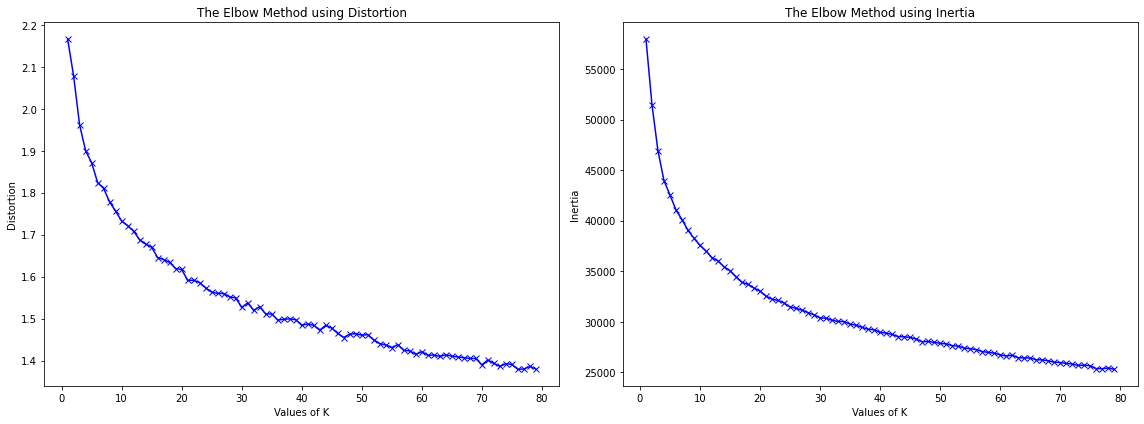

In [161]:
plot_elbow(K, distortions_e, inertias_e)

**Conclusion from plots:** The point after which the distortion/inertia starts decreasing in a linear fashion is now about `k = 22`.

*Note:* An Elbow curve differently from the previous approaches has a **smooth** shape.

### **Fitting the model with prepared data and found `k`**

In [34]:
#here we use reduced dataset also for the clustering, otherwise it takes too long while for the training
start = timeit.default_timer()

kmeans_e = get_clusters(22, list(data_mini_e))

stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  7.676803990000735


### **Plotting the results**

**1. Visualize the heatmaps to see how recommendations and purchases are clustered**

In [ ]:
#filter the dataset from data raws with reviews that have been converted to NaNs and dropped during preprocessing
#add the cluster label to the dataframe
df_e_filtered  = df_mini[df_mini.index.isin(data_mini_e.index)]
df_e_filtered['cluster'] = kmeans_e.labels_

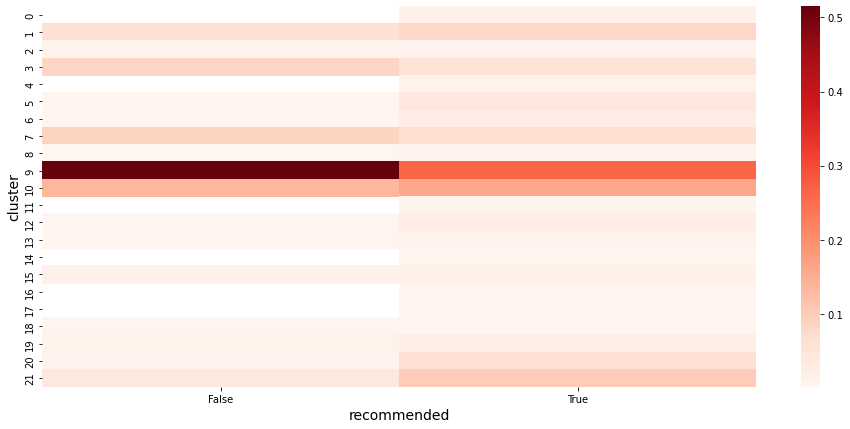

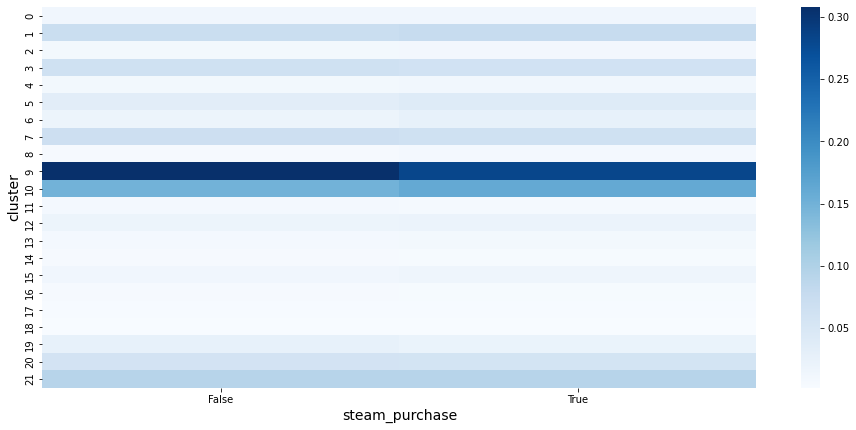

In [42]:
plot_heatmap(df_e_filtered)

**Conclusion from plots:** Obtained clusters still don't capture groups of reviewers who tends recommend or purchase items.

**2. Plots of the clusters with data projected to 2D and 3D using `pca` from Scikit Learn**

The third time displaying scatter plots of the results of the clustering for the 5000 randomly sampled items and comparing them with the results of the clustering based on the previous two approaches, we can determine if GloVe ability to derive semantic relationships between words from the co-occurrence matrix helps to solve the given problem.

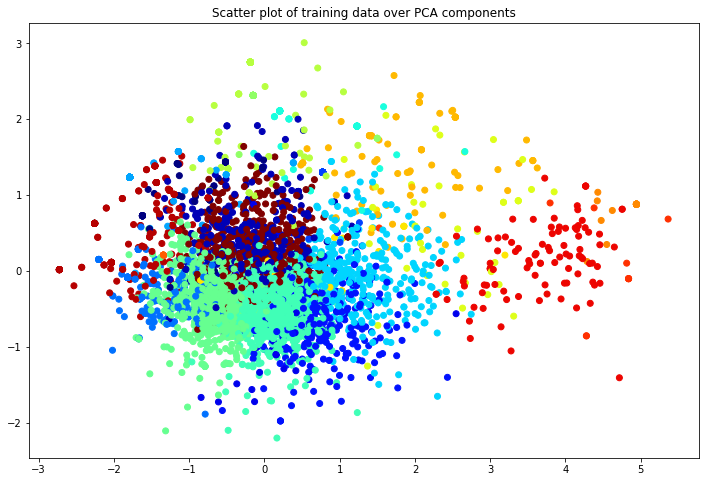

In [47]:
#2D plot
plot_scatter(2, df_e_filtered, 5000, None, "e")

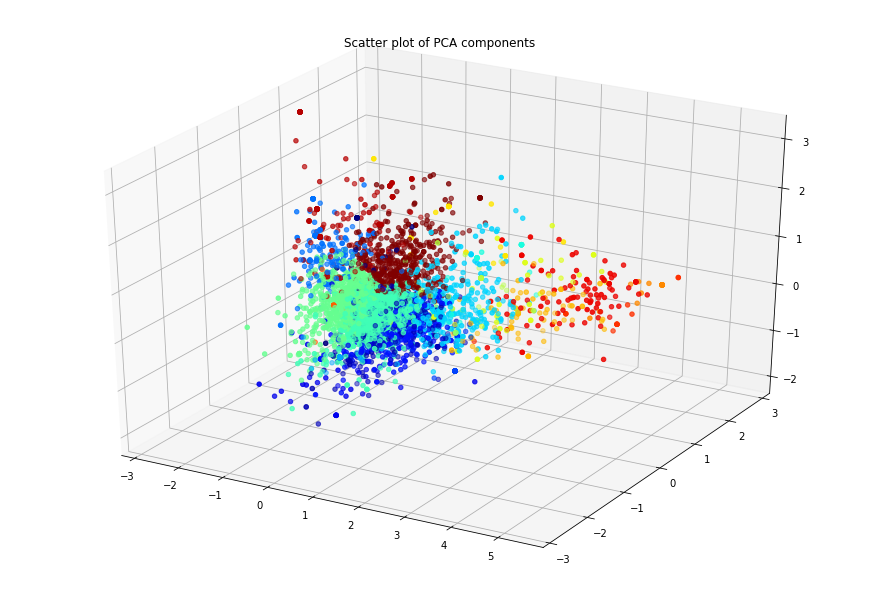

In [48]:
#3D plot
plot_scatter(3, df_e_filtered, 5000, None, "e")

**Conclusion from plots:** It's hard even to visually estimate where the exact borders between the clusters are supposed to lie, but improvement of the results in comparison with the results of the previous experimental set-ups is clearly seen.

*Note:* It was taken into consideration that amount of input data (that has been changed significantly) could also be influencial: in fact, when for the sake of more fair comparison, the same portion of dataframe is used in all four approaches, it shows the results, similar to the currently plotted.

## **FE: PCA**

Finally, progress in the quality of a clustering method measured by its ability to discover some of the hidden patterns has been achieved, but performance in terms of **execution time and memory consumption** appears to be a problem even on the small portions of data. 

The current experimental set-up feature engineering novelty intended to address this challenge by means of **Dimensionality Reduction** with **PCA** method that have been used so far exclusively for the drawing purposes.

### **Preparation of the input data for the clustering**

In [49]:
def prepared_input_pca(review, n_components):
  pca = PCA(n_components = n_components)
  return pca.fit_transform(np.array(list(review)))

In [51]:
#essintially what we do is to take text preprocessed+embedded data input from the previous approach and project it to the lower dimensions
data_mini_pca = prepared_input_pca(data_mini_e, 3)

In [53]:
#resulting data and its shape
print("DATA SHAPE:\n\n", data_mini_pca.shape, "\n\nDATA:\n")
data_mini_pca

DATA SHAPE:

 (9548, 3) 

DATA:



array([[-0.09439801,  0.2513644 , -0.03012405],
       [ 0.09386313, -0.59541274, -0.1381718 ],
       [ 4.78573398,  0.01639281,  0.4206082 ],
       ...,
       [ 1.14466466,  0.10951469,  0.88665261],
       [ 0.43132636,  0.88382142, -1.11797054],
       [-0.63406834, -0.15770931, -0.60941061]])

### **Detection of the optimal `k` with `get_elbow`**

In [54]:
distortions_pca, inertias_pca = get_elbow(K, data_mini_pca, "pca")

100%|██████████| 79/79 [06:37<00:00,  5.03s/it]


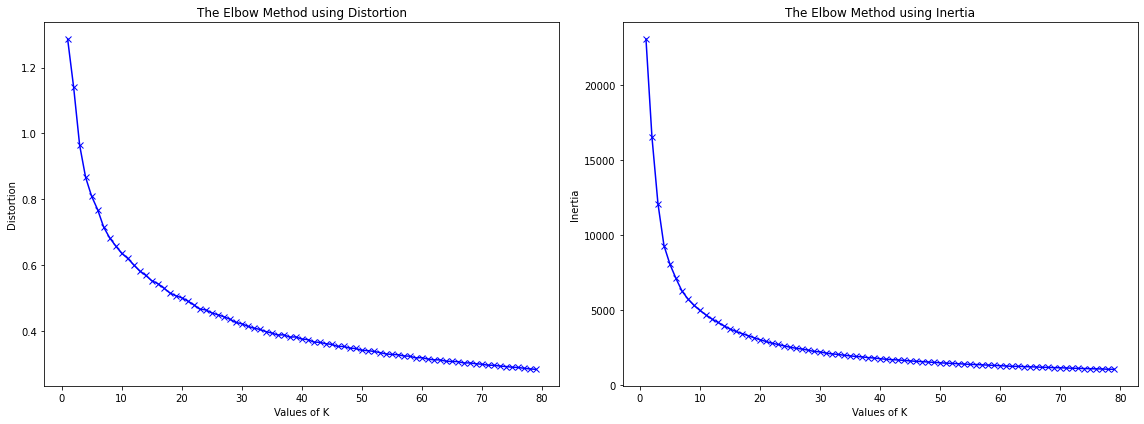

In [57]:
plot_elbow(K, distortions_pca, inertias_pca)

**Conclusion from plots:** The point after which the distortion/inertia starts decreasing in a linear fashion is about `k = 15`.

### **Fitting the model with prepared data and found `k`**

In [58]:
start = timeit.default_timer()

kmeans_pca = get_clusters(15, data_mini_pca)

stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  1.565035244999308


### **Plotting the results**

**1. Visualize the heatmaps to see how recommendations and purchases are clustered**

In [ ]:
#filter the dataset from data raws with reviews that have been converted to NaNs and dropped during preprocessing
#add the cluster label to the dataframe
df_pca_filtered  = df_mini[df_mini.index.isin(data_mini_e.index)]
df_pca_filtered['cluster'] = kmeans_pca.labels_

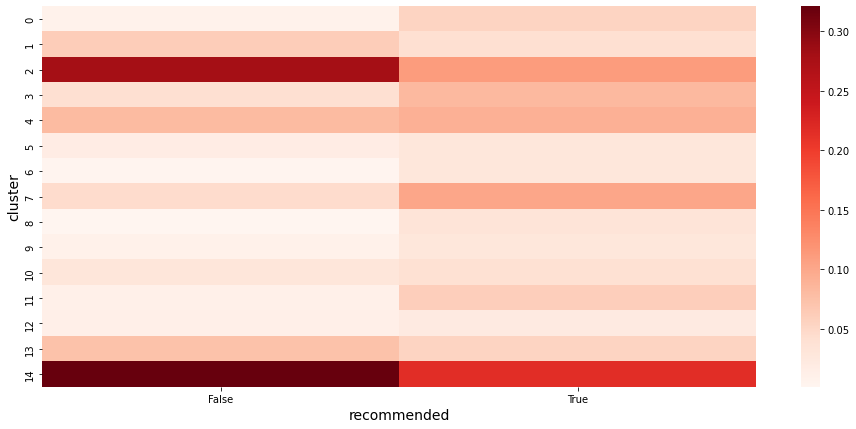

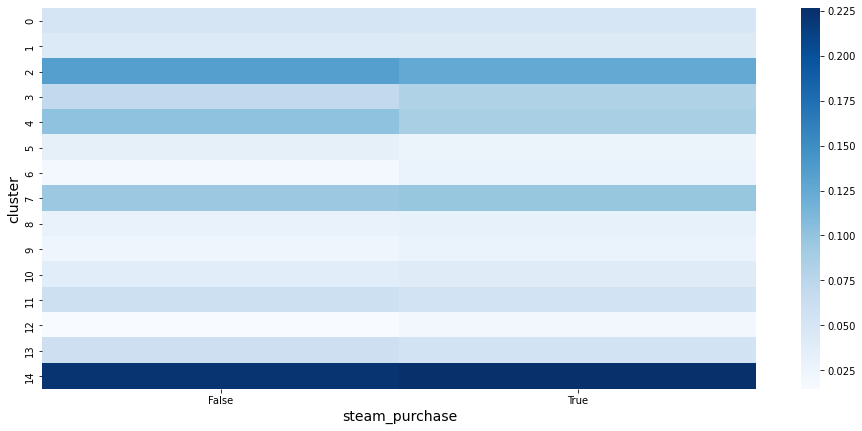

In [60]:
plot_heatmap(df_pca_filtered)

**Conclusion from plots:** Some separation patterns seem to be slightly captured in recommendations, e.g. clusters 7 and 11 contain reviewers who tend to recommend the game, but in general data is still more or less equally distributed between two labels. Therefore, most probably processing of only textual field of the dataframe is not enough to achieve the desired goal.

**2. Plots of the clusters with data projected to 2D and 3D using `pca` from Scikit Learn**

Let's again display the scatter plots of the results of the clustering for the 5000 randomly sampled items and check, if PCA approach employed to provide an acceleration of the training process and more reasonable memory consumption, cnahged also the qualitative results of the clustering.

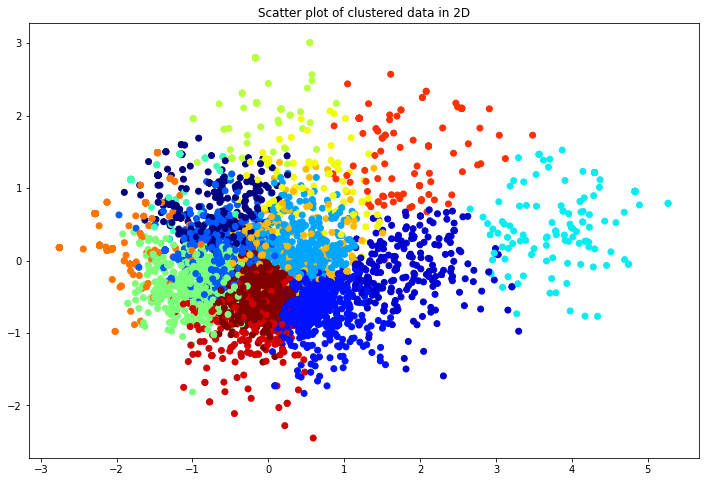

In [62]:
#2D plot
plot_scatter(2, df_pca_filtered, 5000, None, "pca")

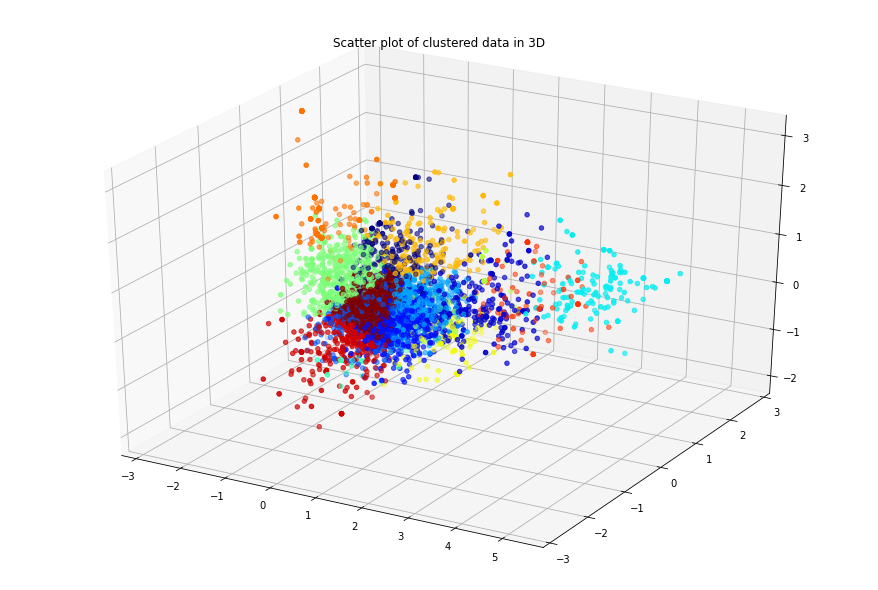

In [63]:
#3D plot
plot_scatter(3, df_pca_filtered, 5000, None, "pca")

**Conclusion from plots:** Separation is a bit more clear (assumingly also because the less number of clusters facilitates visual inspection), but somewhat around the result of the previous approach.